In [10]:
import math
import time
from pathlib import Path

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from data.data_loader import make_loader, XRays_CT_Dataset


from models.unet2d import unet
from models.fullmodel import MultiViewCT
from utils.metrics import psnr
from utils.volume_vis import show_triptych

In [2]:
ANGLES_DEG = [0, 45, 90, 135, 180]
ROOT = "../dataset"
DRR_SIZE = (128, 128)
CT_SIZE  = (128, 128, 128)


CKPT_DIR = Path("./checkpoints_model_fix")
CKPT_DIR.mkdir(parents=True, exist_ok=True)


EPOCHS        = 2000
BASE_LR       = 1e-5
WEIGHT_DECAY  = 1e-5
N_SAMPLES     = 131072
CHUNK_POINTS  = 8192
WARMUP_EPOCHS = 5

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
net2d = unet().to(device)
model = MultiViewCT(
    unet_2d=net2d,
    Z=CT_SIZE[0], Y=CT_SIZE[1], X=CT_SIZE[2],
    feat_ch=128,       # must match U-Net output channels
    pe_dim=9,
    inr_hidden=128,
    inr_blocks_view=3,
    inr_blocks_global=2,
    emb_dim=128,
    inr_out=1
).to(device)

print("Model ready on", device)

/home/micn/anaconda3/envs/istiak/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Model ready on cuda


In [5]:
loader = make_loader(
    root=ROOT,
    angles_deg=ANGLES_DEG,
    drr_size=DRR_SIZE,
    ct_size=CT_SIZE,
    batch_size=1,
    shuffle=True,
)

subset_loader = DataLoader(
    torch.utils.data.Subset(loader.dataset, [i for i in range(200)]),
    batch_size=1,
    shuffle=False,
)

len(subset_loader), len(loader.dataset)

(200, 266)

In [6]:

crit = nn.MSELoss()

optimG = optim.Adam(
    model.parameters(),
    lr=BASE_LR,
    weight_decay=WEIGHT_DECAY,
)

def lr_lambda(epoch):
    """
    - Linear warmup from 0 -> 1 during WARMUP_EPOCHS.
    - Then cosine decay from 1 -> 0.3.
    """
    if epoch < WARMUP_EPOCHS:
        return float(epoch + 1) / float(WARMUP_EPOCHS)
    else:
        t = (epoch - WARMUP_EPOCHS) / max(1, (EPOCHS - WARMUP_EPOCHS))
        cosine = 0.5 * (1 + math.cos(math.pi * t))  # 1 -> 0
        min_factor = 0.3
        return min_factor + (1 - min_factor) * cosine

scheduler = optim.lr_scheduler.LambdaLR(optimG, lr_lambda=lr_lambda)

# Training

In [7]:
def make_scheduler(optimG, last_epoch):
    return torch.optim.lr_scheduler.LambdaLR(
        optimG,
        lr_lambda=lr_lambda,
        last_epoch=last_epoch
    )

In [12]:
def train_model(
    model,
    optimG,
    scheduler_fn,
    CKPT_DIR,
    resume_epoch=None,
    total_epochs=EPOCHS,
):
    """
    Train or resume the model.

    model:      the neural network
    optimG:     optimizer instance
    scheduler_fn: a function that returns a scheduler given (optimG, start_epoch)
    CKPT_DIR:   folder containing checkpoints
    resume_epoch:
        None  : resume from latest checkpoint if any exists
        int>0 : resume from a specific epoch
        <=0   : start from scratch
    total_epochs:
        maximum number of epochs to train
    """

    start_epoch = 0
    ckpt_path = None

    ckpt_files = sorted(CKPT_DIR.glob("model_epoch*.pt"))

    if resume_epoch is None:
        # Use the latest checkpoint if any exists
        if ckpt_files:
            ckpt_path = ckpt_files[-1]

    elif isinstance(resume_epoch, int) and resume_epoch > 0:
        # Use a specific epoch checkpoint
        ckpt_name = f"model_epoch{resume_epoch:04d}.pt"
        candidate = CKPT_DIR / ckpt_name
        if candidate.exists():
            ckpt_path = candidate
        else:
            raise FileNotFoundError(f"Checkpoint not found: {candidate}")

    else:
        # resume_epoch <= 0 → start from scratch
        ckpt_path = None

    if ckpt_path is not None:
        print(f"Resuming from checkpoint: {ckpt_path}")
        ckpt = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optimG.load_state_dict(ckpt["optimizer_state"])
        start_epoch = ckpt.get("epoch", 0)

    else:
        print("No checkpoint loaded, starting from scratch.")
        start_epoch = 0

    # Recreate scheduler with the correct last_epoch
    scheduler = scheduler_fn(optimG, last_epoch=start_epoch - 1)

    print(f"Training will start at epoch {start_epoch+1} / {total_epochs}")
    print("Start training")

    for epoch in range(start_epoch, total_epochs):
        model.train()
        running_loss = 0.0
        n_batches = len(subset_loader)

        for batch_idx, batch in enumerate(subset_loader):
            views  = batch["views"].to(device, dtype=torch.float32)    # (B, V, 1, H, W)
            angles = batch["angles"].to(device, dtype=torch.float32)   # (B, V)
            ct     = batch["ct"].to(device, dtype=torch.float32)       # (B, 1, Z, Y, X)

            # Handle shape (B, 1, 1, Z, Y, X) : squeeze extra dim
            if ct.ndim == 6 and ct.shape[2] == 1:
                ct = ct.squeeze(2)

            B, _, Z, Y, X = ct.shape
            N_vox = Z * Y * X

            assert N_vox == model.coords.shape[0], (
                f"Grid mismatch: ct has {N_vox} voxels, "
                f"coords has {model.coords.shape[0]}"
            )

            # Random voxel sampling
            n_use = min(N_SAMPLES, N_vox)
            perm  = torch.randperm(N_vox, device=device)
            idx   = perm[:n_use]

            ct_flat = ct.view(B, -1)
            gt      = ct_flat[:, idx]

            # Forward only on sampled points
            optimG.zero_grad(set_to_none=True)
            pred = model.forward_points(
                views, angles, idx, chunk=CHUNK_POINTS
            )

            loss = crit(pred, gt)
            loss.backward()
            optimG.step()

            running_loss += loss.item()

            if (batch_idx + 1) % 20 == 0:
                print(
                    f"  epoch {epoch+1} | batch {batch_idx+1}/{n_batches} "
                    f"| loss={loss.item():.4e}",
                    end="\r",
                )

        avg_mse  = running_loss / n_batches
        avg_psnr = psnr(avg_mse)
        current_lr = optimG.param_groups[0]["lr"]

        print(
            f"Epoch {epoch+1}/{total_epochs} "
            f"LR:{current_lr:.2e} | "
            f"MSE(subset):{avg_mse:.4e} | PSNR~:{avg_psnr:.2f} dB"
        )

        scheduler.step()

        # Full-volume visualisation every 20 epochs
        if (epoch + 1) % 20 == 0:
            model.eval()
            with torch.no_grad():
                sample = loader.dataset[0]
                v = sample["views"].unsqueeze(0).to(device, dtype=torch.float32)
                a = sample["angles"].unsqueeze(0).to(device, dtype=torch.float32)
                ct_ref = sample["ct"].unsqueeze(0).to(device, dtype=torch.float32)
                if ct_ref.ndim == 6 and ct_ref.shape[2] == 1:
                    ct_ref = ct_ref.squeeze(2)
                pred_full = model(v, a, chunk=CHUNK_POINTS)

            show_triptych(
                pred_full[0, 0].cpu().numpy(),
                ct_ref[0, 0].cpu().numpy(),
                title_prefix=f"Epoch {epoch+1} (full volume)",
            )
            model.train()

        # Checkpoints
        if (epoch + 1) % 10 == 0 or (epoch + 1) == total_epochs:
            ckpt_path = CKPT_DIR / f"model_epoch{epoch+1:04d}.pt"
            torch.save(
                {
                    "epoch": epoch + 1,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimG.state_dict(),
                    "loss": avg_mse,
                },
                ckpt_path,
            )
            print(f"Checkpoint : {ckpt_path}")

Resuming from checkpoint: checkpoints_model_fix/model_epoch0870.pt
Training will start at epoch 871 / 2000
Start training
Epoch 871/2000 LR:7.22e-06 | MSE(subset):5.0332e-03 | PSNR~:22.98 dB
Epoch 872/2000 LR:7.22e-06 | MSE(subset):4.9863e-03 | PSNR~:23.02 dB
Epoch 873/2000 LR:7.21e-06 | MSE(subset):4.9856e-03 | PSNR~:23.02 dB
Epoch 874/2000 LR:7.21e-06 | MSE(subset):4.9391e-03 | PSNR~:23.06 dB
Epoch 875/2000 LR:7.20e-06 | MSE(subset):5.0113e-03 | PSNR~:23.00 dB
Epoch 876/2000 LR:7.20e-06 | MSE(subset):5.0098e-03 | PSNR~:23.00 dB
Epoch 877/2000 LR:7.19e-06 | MSE(subset):4.9952e-03 | PSNR~:23.01 dB
Epoch 878/2000 LR:7.19e-06 | MSE(subset):5.1066e-03 | PSNR~:22.92 dB
Epoch 879/2000 LR:7.18e-06 | MSE(subset):5.0085e-03 | PSNR~:23.00 dB
Epoch 880/2000 LR:7.18e-06 | MSE(subset):5.0225e-03 | PSNR~:22.99 dB


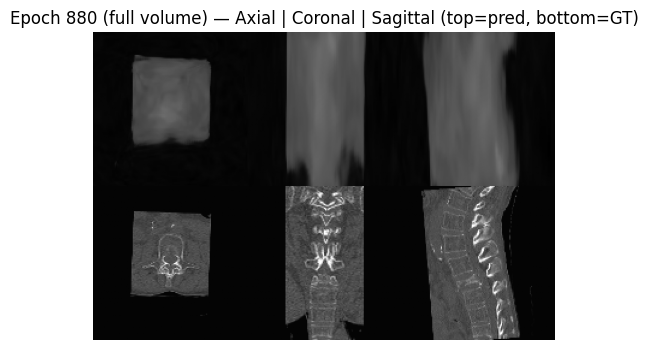

Checkpoint : checkpoints_model_fix/model_epoch0880.pt
Epoch 881/2000 LR:7.17e-06 | MSE(subset):5.0059e-03 | PSNR~:23.01 dB
Epoch 882/2000 LR:7.17e-06 | MSE(subset):5.0443e-03 | PSNR~:22.97 dB
Epoch 883/2000 LR:7.16e-06 | MSE(subset):5.0248e-03 | PSNR~:22.99 dB
Epoch 884/2000 LR:7.15e-06 | MSE(subset):5.0458e-03 | PSNR~:22.97 dB
Epoch 885/2000 LR:7.15e-06 | MSE(subset):5.0118e-03 | PSNR~:23.00 dB


In [ ]:
train_model(model, optimG, make_scheduler, CKPT_DIR, resume_epoch=None)